In [1]:
import torch
import torch.nn.functional as F
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(1024)

In [2]:
class Linear:
    # input:(B,in_features)
    # output:(B,out_features)
    def __init__(self, in_features, out_features, bias=True):
        # 对于模型参数的初始化，故意没有做优化
        self.weight = torch.randn((in_features, out_features), requires_grad=True)  # (in_features,out_features)
        if bias:
            self.bias = torch.randn(out_features, requires_grad=True)  # (out_features)
        else:
            self.bias = None

    def __call__(self, x):  # 方法让类的实例可以像函数一样被调用
        # x:  (B,in_features)
        # self.weight:(in_features,out_features)
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        # 返回模型参数
        if self.bias is not None:
            return [self.weight, self.bias]
        return self.weight

In [3]:
class Sigmoid:
    def __call__(self, x):
        self.out = torch.sigmoid(x)
        return self.out

    @staticmethod
    def parameters():
        return []

In [10]:
class Sequential:
    def __init__(self, layers):
        # layers表示的模型组件，比如线性模型，比如sigmoid
        self.layers = layers

    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        self.out = x
        return self.out

    def parameters(self):
        # k=[]
        # for layer in self.layers():
        #     for p in layer.parameters():
        #          k.append(p)
        return [p for layer in self.layers for p in layer.parameters()]

    def predict_proba(self, x):
        # 计算概率预测
        if isinstance(x, np.ndarray):
            x = torch.tensor(x).float()
        logits = self(x)  # 等价于 self.__call__(x)
        self.prob = F.softmax(logits, dim=-1).detach().numpy()
        return self.prob

In [5]:
# x:(B,2)
# mlp:[4,4,2]
model = Sequential([
    Linear(2, 4), Sigmoid(),  # （B，4）
    Linear(4, 4), Sigmoid(),  # （B，4）
    Linear(4, 2)  # （B，2）
])
x = torch.randn(3, 2)
model(x)

tensor([[-0.6104, -2.2072],
        [-0.5949, -2.1857],
        [-0.3821, -2.1816]], grad_fn=<AddBackward0>)

In [6]:
print(model.predict_proba(x))

[[0.8315643  0.16843568]
 [0.8307276  0.16927248]
 [0.85809493 0.14190508]]


In [7]:
def draw_data(data):
    """
    数据可视化
    """
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    x, y = data
    label1 = x[y > 0]
    ax.scatter(label1[:, 0], label1[:, 1], marker='o')
    label0 = x[y == 0]
    ax.scatter(label0[:, 0], label0[:, 1], marker='^', color='k')
    return ax


def draw_model(ax, model):
    """
    将模型的分离超平面可视化
    """
    x1 = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
    x2 = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100)
    x1, x2 = np.meshgrid(x1, x2)
    y = model.predict_proba(np.c_[x1.ravel(), x2.ravel()])[:, 1]
    y = y.reshape(x1.shape)
    ax.contourf(x1, x2, y, levels=[0, 0.5], colors=['gray'], alpha=0.4)
    return ax

<Axes: >

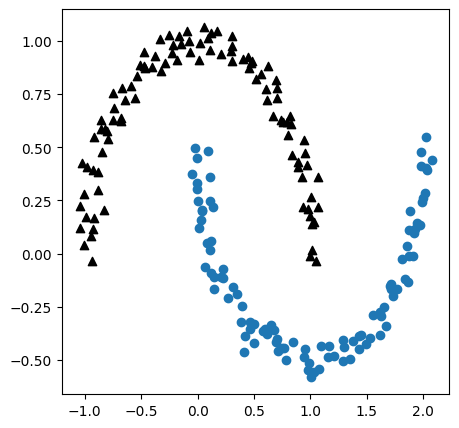

In [8]:
from sklearn.datasets import make_moons

data = make_moons(200, noise=0.05)
draw_data(data)

In [13]:
batch_size = 20
max_steps = 40000
learning_rate = 0.1
x, y = torch.tensor(data[0]).float(), torch.tensor(data[1])
model = Sequential([
    Linear(2, 4), Sigmoid(),  # （B，4）
    Linear(4, 4), Sigmoid(),  # （B，4）
    Linear(4, 2)  # （B，2）
])
lossi = []

for epoch in range(max_steps):
    ix = (epoch * batch_size) % len(x)
    xx = x[ix:ix + batch_size]
    yy = y[ix:ix + batch_size]
    logits = model(xx)
    loss = F.cross_entropy(logits, yy)
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p -= learning_rate * p.grad
            p.grad = None
    if epoch % 200 == 0:
        print(f'step{epoch}, loss{loss.item()}')
    lossi.append(loss.item())

step0, loss0.6956738829612732
step200, loss0.6068126559257507
step400, loss0.3847286105155945
step600, loss0.22746601700782776
step800, loss0.1514061689376831
step1000, loss0.11398601531982422
step1200, loss0.09557627141475677
step1400, loss0.08618849515914917
step1600, loss0.08120669424533844
step1800, loss0.07848697900772095
step2000, loss0.07697002589702606
step2200, loss0.07610350847244263
step2400, loss0.07559039443731308
step2600, loss0.07526935636997223
step2800, loss0.07505282014608383
step3000, loss0.07489346712827682
step3200, loss0.07476513087749481
step3400, loss0.07465286552906036
step3600, loss0.07454705983400345
step3800, loss0.0744401067495346
step4000, loss0.0743246078491211
step4200, loss0.0741920992732048
step4400, loss0.07403234392404556
step4600, loss0.07383273541927338
step4800, loss0.07357834279537201
step5000, loss0.07325290143489838
step5200, loss0.07284043729305267
step5400, loss0.07232795655727386
step5600, loss0.0717085674405098
step5800, loss0.0709837824106

<Axes: >

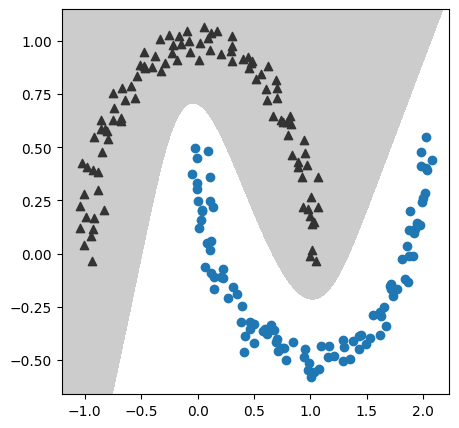

In [14]:
ax = draw_data(data)
draw_model(ax, model)